# Update OISST Anomalies

**Objective: Bring in new year(s) of OISST Data, get all the related products without re-calculating the climatologies etc.**

## Product 1: Sea Surface Temperature Anomalies

NOTE: As of this date 9/10/2020, must be done outside of docker environment. So to execute this code, exit the docker environment with `make down` then proceed to activate the `py36` conda environment and open `Jupyter lab` from the terminal. From there we proceed to updating OISST products.


**Updated Products:**
 * Daily OISST Anomalies (from 1982 to 2011 climatology)

In [15]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import oisstools as ot
import cartopy.crs as ccrs

# Set Notebook Options:
workspace = "local"
reference_period = "1982-2011"

# Set the workspace - local/ docker
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}

box_root = root_locations[workspace]


# Set climatology source choices
climatologies = {"1982-2011" : "1982to2011_climatology",
                 "1991-2020" : "1991to2020_climatology"}

climate_period = climatologies[reference_period]

# document what choices were made on last run:
print(f"Working via {workspace} directory at: {box_root}")
print(f"Calculating Anomalies for {reference_period} reference period using {climate_period}")

Working via local directory at: /Users/akemberling/Box/
Calculating Anomalies for 1982-2011 reference period using 1982to2011_climatology


## Set Update Parameters

This notebook is organized to take a handful parameters in the beginning which will guide what data is updated and how it is appended to the full products.

In [16]:
# Specify year range to update
yr_min = 2021
yr_max = 2021
update_yrs = range(yr_min, yr_max + 1)
print(f"Updating Year(s): {yr_min} - {yr_max}")

Updating Year(s): 2021 - 2021


## Load the data to append

As a first step, the data we wish to update and extend our products with needs to be brought into the environment. Newer observations can be downloaded directly from: [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html)

These files (organized by year) are the same formatting as the other years that have been downloaded. Alternatively, OISSTv2 data can be accessed via [https://www.ncdc.noaa.gov/oisst/data-access](https://www.ncdc.noaa.gov/oisst/data-access)

In [17]:
# Append Global netcdf paths together
fpaths = []
for yr in update_yrs:
    fpaths.append(f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)

# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
# modified ordinal day function moved to oisstools module for consistency across notebooks
oisst = ot.add_mod(oisst, 'time')
oisst

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 64)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * time                  (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-03-05T12:00:00
    MOD                   (time) int64 1 2 3 4 5 6 7 8 ... 58 59 61 62 63 64 65
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(64, 720, 1440), meta=np.ndarray>
    modified_ordinal_day  (time) int64 1 2 3 4 5 6 7 8 ... 58 59 61 62 63 64 65
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

## Load Global Climatology

The global climatology is generated in the notebook: `01_OISST_calc_climatology`. The years covered are 1982-2011, the extent is global, and the resolution is the same as OISSTv2 data at 1/4 degree cells.

In [18]:
# Load Global Climatology
oisst_clim = xr.open_dataset('~/Box/RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc')

# Calculate Global Anomalies


In [19]:
# Get anomalies
daily_anoms = oisst.groupby('time').map(lambda x: ot.calc_anom(x, oisst_clim))

## Plot test

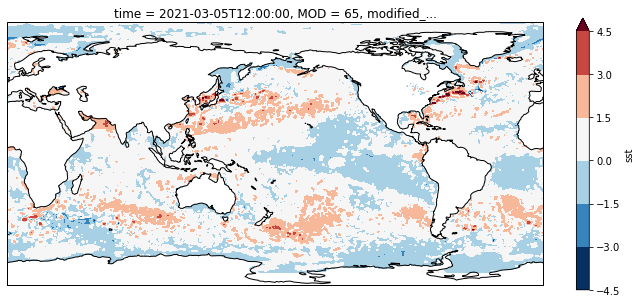

In [20]:
# Plot most recent day

# setup
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree(central_longitude=180))

# data
daily_anoms.isel(time = -1)['sst'].plot.contourf(
    ax = ax,
    levels = np.arange(-4.5, 6, 1.5),
    extend = 'max',
    transform = ccrs.PlateCarree())

# add coastlines and plot
ax.coastlines()
plt.show()

### Inspect Format

In [21]:
# check format one last time
daily_anoms

,Array,Chunk
Bytes,265.42 MB,4.15 MB
Shape,"(64, 720, 1440)","(1, 720, 1440)"
Count,322 Tasks,64 Chunks
Type,float32,numpy.ndarray


## Save, close netcdf files

In [23]:
#Export as annual netcdf files
for year, group in daily_anoms.groupby('time.year'):
    out_path = f'{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/{climate_period}/daily_anoms_{year}.nc'
    #print(out_path)
    group.to_netcdf(out_path)
    print(f"Saving anomaly year: {year}")

Saving anomaly year: 2021


In [24]:
# Close netcdf files
oisst.close()
daily_anoms.close()
oisst_clim.close()